# Introduction to SciPy
Tutorial at EuroSciPy 2019, Bilbao

## The hanging chain – Optimization

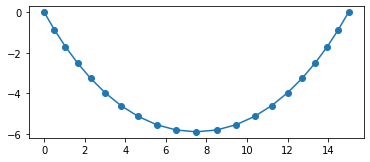

In [1]:
import numpy as np
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt


class Chain:
    def __init__(self, nlinks, hdist):
        if nlinks < hdist:
            raise ValueError('a hanging chain with {} links of '
                             'length 1 cannot have endpoints '
                             'separated by a distance {}'.format(
                                    nlinks, hdist))
        self.nlinks = nlinks
        self.hdist = hdist
 
    def equilibrium(self):
        phi0 = np.arcsin(self.hdist/self.nlinks)
        result = optimize.minimize(
                     self.f_energy,
                     np.linspace(-phi0, phi0, self.nlinks),
                     method='SLSQP',
                     constraints=[{'type': 'eq', 'fun': self.x_constraint},
                                  {'type': 'eq', 'fun': self.y_constraint}])
        return result.x
    
    def x_constraint(self, phi_vals):
        """ensure the correct horizontal distance
        
           phi_vals: angles of links with respect to the horizontal
           
        """
        return np.sum(np.cos(phi_vals))-self.hdist 
       
    def y_constraint(self, phi_vals):
        """ensure that endpoints are at the same height
        
           phi_vals: angles of links with respect to the horizontal
           
        """
        return np.sum(np.sin(phi_vals))

    def f_energy(self, phi_vals):
        """potential energy of all links
        
        """
        return np.sum(np.arange(self.nlinks, 0, -1)*np.sin(phi_vals))
    
    @classmethod
    def angles_to_coords(Chain, phi_vals):
        """convert angles to coordinates of link endpoints
        
           phi_vals: angles of links with respect to the horizontal
           x, y: coordinates of link endpoints
           
        """
        dim = phi_vals.shape[0]+1
        x = np.zeros(dim)
        x[1:] = np.cumsum(np.cos(phi_vals))
        y = np.zeros(dim)
        y[1:] = np.cumsum(np.sin(phi_vals))
        return x, y

        
c = Chain(20, 15)
plt.axes().set_aspect('equal')
plt.plot(*Chain.angles_to_coords(c.equilibrium()), 'o-')

## The falling chain – Solving a set of ordinary differential equations

#### Literature    
W. Tomaszewski, P. Pieranski, J.-C. Geminard    
*The motion of a free falling chain tip*    
[American Journal of Physics **74**, 776 (2006)](https://dx.doi.org/10.1119/1.2204074)

#### Equations of motion

$$\sum_{j=1}^n m_{i,j}\cos(\varphi_i-\varphi_j)\ddot\varphi_j
  = -\sum_{j=1}^n m_{i, j}\sin(\varphi_i-\varphi_j)\dot\varphi_j^2
    +\frac{r}{m\ell^2}(\dot\varphi_{i-1}-2\dot\varphi_i+\dot\varphi_{i+1})
    -\frac{g}{\ell}a_i\cos(\varphi_i)$$
with
$$a_i = n-i+\frac{1}{2}$$
and
$$m_{i,j} = \begin{cases}
            n-i+\frac{1}{3} & i=j \\
            n-\max(i,j)+\frac{1}{2} & i\neq j
            \end{cases}$$


































In [3]:
%%capture
# The following line should be part of the animation method below.
# However, putting it there will to an undesired extra static image.
fig = plt.figure()

In [ ]:
import numpy.linalg as LA
from scipy import integrate
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')

class FallingChain(Chain):
    def __init__(self, nlinks, hdist, damping):
        super(FallingChain, self).__init__(nlinks, hdist)
        self.damping = damping
        self.m = self.matrix_m()
        self.a = self.vector_a()
        
    def matrix_m(self):
        m = np.fromfunction(lambda i, j: self.nlinks-np.maximum(i, j)-0.5,
                            (self.nlinks, self.nlinks))
        m = m-np.identity(self.nlinks)/6
        return m

    def vector_a(self):
        a = np.arange(self.nlinks, 0, -1)-0.5
        return a

    def solve_eq_of_motion(self, time_i, time_f, nt):
        y0 = np.zeros(2*self.nlinks, dtype=np.float64)
        y0[self.nlinks:] = self.equilibrium()
        self.solution = integrate.solve_ivp(
                            self.diff, (time_i, time_f), y0,
                            method='Radau',
                            t_eval=np.linspace(time_i, time_f, nt))

    def diff(self, t, y):
        momenta = y[:self.nlinks]
        angles = y[self.nlinks:]
        d_angles = momenta
        ci = np.cos(angles)
        cij = np.cos(angles[:, np.newaxis]-angles)
        sij = np.sin(angles[:, np.newaxis]-angles)
        mcinv = LA.inv(self.m*cij)
        d_momenta = -np.dot(self.m*sij, momenta*momenta)
        d_momenta = d_momenta + np.dot(self.damping, momenta)
        d_momenta = d_momenta - self.a*ci
        d_momenta = np.dot(mcinv, d_momenta)
        d = np.empty_like(y)
        d[:self.nlinks] = d_momenta
        d[self.nlinks:] = d_angles
        return d
    
    def animate(self, i):
        x, y = Chain.angles_to_coords(self.solution.y[:, i][self.nlinks:])
        self.line.set_data(x, y)
        return self.line,

    def init(self):
        self.line.set_data([], [])
        return self.line,

    def animation(self, ti, tf, tsteps):
        self.solve_eq_of_motion(ti, tf, tsteps)
        nlinks = self.nlinks
        ax = fig.add_subplot(111, autoscale_on=False,
                             xlim=(-nlinks, nlinks), ylim=(-nlinks, 0.3*nlinks))
        ax.set_aspect('equal')
        self.line, = ax.plot([], [])
        anim = animation.FuncAnimation(fig, self.animate, tsteps,
                                       interval=100, blit=True,
                                       init_func=self.init)
        return anim
      
c = FallingChain(200, 100, 0.01)
c.animation(0, 60, 60)